# Tiền xử lý dữ liệu

## Chuẩn bị thư viện


In [1]:
# 1. Import thư viện
import os
import json
import cv2
import numpy as np
from tqdm import tqdm

## Tải Class mapping

In [2]:
# 2. Load class mapping
with open('../data/split_data/class_mapping.json', 'r') as f:
    class_mapping = json.load(f)

# Chuyển key từ string sang int
class_mapping = {int(k): v for k, v in class_mapping.items()}

print(f"Số lớp: {len(class_mapping)}")
print(f"Classes: {list(class_mapping.values())}")

Số lớp: 23
Classes: ['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


## Định nghia hàm preprocessing cho histogram

In [3]:
# 3. Định nghĩa hàm preprocessing với histogram
IMAGE_SIZE = (224, 224)

# Preprocessing với histogram equalization
def preprocess_histogram(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    # Resize
    img = cv2.resize(img, IMAGE_SIZE)
    
    # Chuyển sang HSV để áp dụng histogram equalization
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Áp dụng histogram equalization trên kênh V (Value/Brightness)
    img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])
    
    # Chuyển về RGB
    img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    
    # Normalize 0-1
    img = img.astype('float32') / 255.0
    
    return img

print(f"✓ Image size: {IMAGE_SIZE}")
print(f"✓ Method: Histogram Equalization (HSV)")

✓ Image size: (224, 224)
✓ Method: Histogram Equalization (HSV)


### Preprocessing với tập train

In [4]:
# 4. Load và xử lý train data
print("\nĐang load train data...")
train_dir = '../data/split_data/train'
X_train = []
y_train = []

for class_idx, class_name in class_mapping.items():
    class_path = os.path.join(train_dir, class_name)
    if not os.path.exists(class_path):
        continue
    
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    
    for img_file in tqdm(images, desc=f"Train {class_name}"):
        img_path = os.path.join(class_path, img_file)
        img = preprocess_histogram(img_path)
        
        if img is not None:
            X_train.append(img)
            y_train.append(class_idx)

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"✓ Train shape: {X_train.shape}")


Đang load train data...


Train Whale: 100%|██████████| 458/458 [00:00<00:00, 727.96it/s]


✓ Train shape: (10968, 224, 224, 3)


### Preprocessing với tập test

In [5]:
# 5. Load và xử lý test data
print("\nĐang load test data...")

test_dir = '../data/split_data/test'
X_test = []
y_test = []

for class_idx, class_name in class_mapping.items():
    class_path = os.path.join(test_dir, class_name)
    if not os.path.exists(class_path):
        continue
    
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    
    for img_file in tqdm(images, desc=f"Test {class_name}"):
        img_path = os.path.join(class_path, img_file)
        img = preprocess_histogram(img_path)
        
        if img is not None:
            X_test.append(img)
            y_test.append(class_idx)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"✓ Test shape: {X_test.shape}")


Đang load test data...


Test Whale: 100%|██████████| 114/114 [00:00<00:00, 926.79it/s]


✓ Test shape: (2743, 224, 224, 3)


## Lưu file preprocessing

In [6]:
# 6. Lưu file .npz
output_dir = '../data/preprocessed_histogram'
os.makedirs(output_dir, exist_ok=True)

# Lưu train data
np.savez_compressed(
    f'{output_dir}/train_data.npz',
    X=X_train,
    y=y_train
)

# Lưu test data
np.savez_compressed(
    f'{output_dir}/test_data.npz',
    X=X_test,
    y=y_test
)

# Lưu class mapping
with open(f'{output_dir}/class_mapping.json', 'w') as f:
    json.dump(class_mapping, f, indent=2, ensure_ascii=False)

# Lưu preprocessing info
preprocessing_info = {
    'method': 'Histogram Equalization',
    'color_space': 'HSV -> RGB',
    'image_size': IMAGE_SIZE,
    'normalization': '0-1',
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'num_classes': len(class_mapping)
}

with open(f'{output_dir}/preprocessing_info.json', 'w') as f:
    json.dump(preprocessing_info, f, indent=2)

print("Đã lưu train_data.npz, test_data.npz và metadata")


Đã lưu train_data.npz, test_data.npz và metadata


# Trích xuất đặc trưng histogram

## Chuẩn bị thư viện

In [7]:
# 1. Import thư viện
import os
import json
import numpy as np
from tqdm import tqdm

## Tải dữ liệu đã tiền xử lý

In [8]:
# 2. Load ảnh đã preprocessing
print("Đang load ảnh đã preprocessing...")

# Load train data
train_data = np.load('../data/preprocessed_histogram/train_data.npz')
X_train_img = train_data['X']
y_train = train_data['y']

# Load test data
test_data = np.load('../data/preprocessed_histogram/test_data.npz')
X_test_img = test_data['X']
y_test = test_data['y']

# Load class mapping
with open('../data/preprocessed_histogram/class_mapping.json', 'r') as f:
    class_mapping = json.load(f)
class_mapping = {int(k): v for k, v in class_mapping.items()}

print(f"✓ Train images: {X_train_img.shape}")
print(f"✓ Test images: {X_test_img.shape}")
print(f"✓ Số lớp: {len(class_mapping)}")

Đang load ảnh đã preprocessing...
✓ Train images: (10968, 224, 224, 3)
✓ Test images: (2743, 224, 224, 3)
✓ Số lớp: 23


## Hàm trích xuất đặc trưng histogram

In [9]:
# 3. Định nghĩa hàm trích xuất color histogram features
NUM_BINS = 32  # Số bins cho mỗi kênh màu

def extract_color_histogram(img):
    # Trích xuất color histogram features từ ảnh RGB đã normalize
    # Chuyển về giá trị 0-255 để tính histogram
    img_255 = (img * 255).astype('uint8')
    
    hist_features = []
    
    # Tính histogram cho 3 kênh màu
    for channel in range(3):  # R, G, B
        hist, _ = np.histogram(img_255[:, :, channel], bins=NUM_BINS, range=(0, 256))
        # Normalize histogram
        hist = hist.astype('float32') / (img_255.shape[0] * img_255.shape[1])
        hist_features.extend(hist)
    
    return np.array(hist_features)

print(f"✓ Số bins mỗi kênh: {NUM_BINS}")
print(f"✓ Feature vector length: {NUM_BINS * 3} dimensions")


✓ Số bins mỗi kênh: 32
✓ Feature vector length: 96 dimensions


## Trích xuất đặc trưng cho tập train

In [10]:
# 4. Trích xuất features từ train data
print("\nĐang trích xuất train features...")

X_train_features = []
for img in tqdm(X_train_img, desc="Train"):
    features = extract_color_histogram(img)
    X_train_features.append(features)

X_train_features = np.array(X_train_features)

print(f"✓ Train features shape: {X_train_features.shape}")


Đang trích xuất train features...


Train: 100%|██████████| 10968/10968 [00:24<00:00, 451.53it/s]

✓ Train features shape: (10968, 96)


## Trích xuất dặc trưng cho tập test

In [11]:
# 5. Trích xuất features từ test data
print("\nĐang trích xuất test features...")

X_test_features = []
for img in tqdm(X_test_img, desc="Test"):
    features = extract_color_histogram(img)
    X_test_features.append(features)

X_test_features = np.array(X_test_features)

print(f"✓ Test features shape: {X_test_features.shape}")


Đang trích xuất test features...


Test: 100%|██████████| 2743/2743 [00:05<00:00, 484.55it/s]

✓ Test features shape: (2743, 96)


## Lưu file trích xuất đặc trưng

In [12]:
# 6. Lưu features
print("\nĐang lưu features...")

output_dir = '../data/features_color_histogram'
os.makedirs(output_dir, exist_ok=True)

# Lưu train features
np.savez_compressed(
    f'{output_dir}/train_features.npz',
    X=X_train_features,
    y=y_train
)

# Lưu test features
np.savez_compressed(
    f'{output_dir}/test_features.npz',
    X=X_test_features,
    y=y_test
)

# Lưu class mapping
with open(f'{output_dir}/class_mapping.json', 'w') as f:
    json.dump(class_mapping, f, indent=2, ensure_ascii=False)

# Lưu feature info
feature_info = {
    'method': 'Color Histogram',
    'num_bins_per_channel': NUM_BINS,
    'num_channels': 3,
    'feature_vector_length': NUM_BINS * 3,
    'train_samples': len(X_train_features),
    'test_samples': len(X_test_features),
    'num_classes': len(class_mapping)
}

with open(f'{output_dir}/feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print("✓ Đã lưu train_features.npz, test_features.npz và metadata")



Đang lưu features...
✓ Đã lưu train_features.npz, test_features.npz và metadata


# Huấn luyện mô hình SVC 

## Chuẩn bị thư viện

In [13]:
# 1. Import thư viện
import os
import json
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib

## Load dữ liệu đặc trưng để huấn luyện mô hình

In [14]:
# 2. Load ảnh đã trích xuất đặc trưng
print("Đang load features...") 
# Load train data
train_data = np.load('../data/features_color_histogram/train_features.npz')
X_train = train_data['X']
y_train = train_data['y']
# Load test data
test_data = np.load('../data/features_color_histogram/test_features.npz')
X_test = test_data['X']
y_test = test_data['y']
# Load class mapping
with open('../data/features_color_histogram/class_mapping.json', 'r') as f:
    class_mapping = json.load(f)
class_mapping = {int(k): v for k, v in class_mapping.items()}                   
print(f"✓ Train features: {X_train.shape}")
print(f"✓ Test features: {X_test.shape}")
print(f"✓ Số lớp: {len(class_mapping)}")

Đang load features...
✓ Train features: (10968, 96)
✓ Test features: (2743, 96)
✓ Số lớp: 23


## Chuẩn hoá dữ liệu

In [15]:
scaler = StandardScaler()
# Chuẩn hóa dữ liệu
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Train scaled shape: {X_train.shape}")
print(f"Test scaled shape: {X_test.shape}")


Train scaled shape: (10968, 96)
Test scaled shape: (2743, 96)


## Khởi tạo mô hình SVC và huấn luyện

In [16]:
# 3. Khởi tạo mô hình với tham số cơ bản, classweight cân bằng
model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)

# 4. Huấn luyện mô hình
print("\nĐang huấn luyện mô hình...")
model.fit(X_train, y_train)
print("✓ Huấn luyện xong.")


Đang huấn luyện mô hình...
✓ Huấn luyện xong.


## Đánh giá SVC với tham số mặc định và classweight cân bằng

                 precision    recall  f1-score   support

          Clams       0.10      0.14      0.11        99
         Corals       0.13      0.23      0.17       100
          Crabs       0.23      0.74      0.36       100
        Dolphin       0.27      0.31      0.29       157
            Eel       0.09      0.02      0.03        99
           Fish       0.05      0.01      0.02        99
     Jelly Fish       0.43      0.67      0.53       169
        Lobster       0.06      0.03      0.04       100
    Nudibranchs       0.11      0.17      0.13       100
        Octopus       0.17      0.02      0.03       112
          Otter       0.31      0.70      0.43       100
        Penguin       0.19      0.23      0.21        96
        Puffers       0.05      0.01      0.02       106
       Sea Rays       0.14      0.07      0.09       103
    Sea Urchins       0.25      0.33      0.28       116
       Seahorse       0.14      0.10      0.12        96
           Seal       0.18    

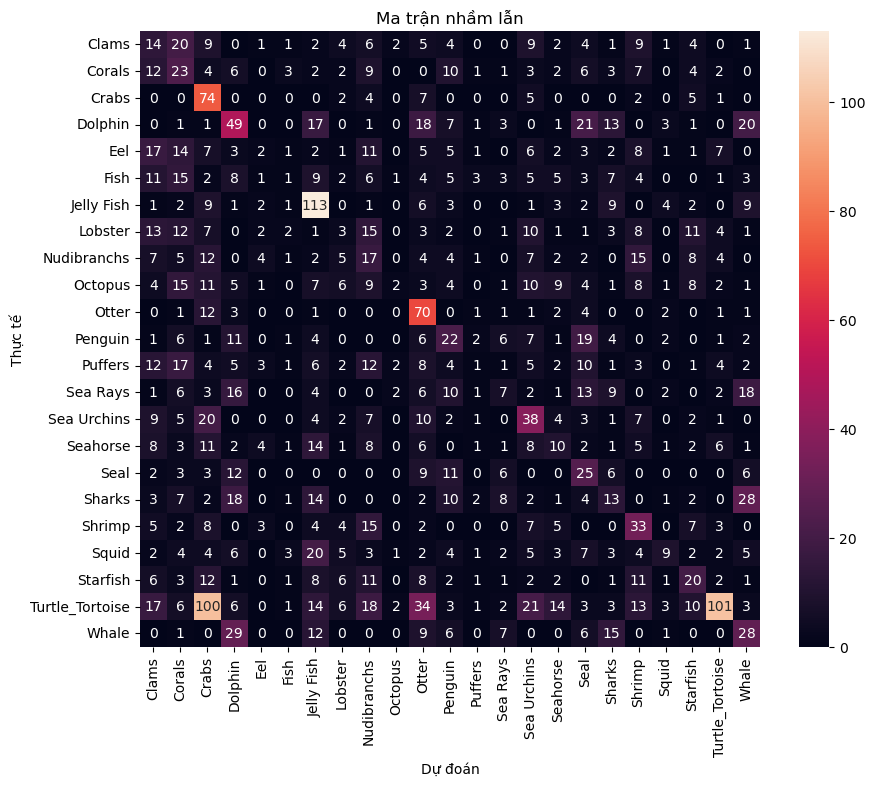

In [17]:
# 5. Đánh giá mô hình
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=[class_mapping[i] for i in range(len(class_mapping))]))

# Hiển thị ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[class_mapping[i] for i in range(len(class_mapping))], yticklabels=[class_mapping[i] for i in range(len(class_mapping))])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn')
plt.show()

## Lưu mô hình SVC

In [28]:
# Lưu scaler
scaler_output_path = '../models/scaler_color_histogram.pkl'
joblib.dump(scaler, scaler_output_path)
print(f"✓ Đã lưu scaler tại {scaler_output_path}")

# Save mô hình
model_output_path = '../models/svc_color_histogram.pkl'
joblib.dump(model, model_output_path)
print(f"✓ Đã lưu mô hình tại {model_output_path}")

✓ Đã lưu scaler tại ../models/scaler_color_histogram.pkl
✓ Đã lưu mô hình tại ../models/svc_color_histogram.pkl


# Sử dụng GridSearch CV cho mô hình SVC

## Chuẩn bị thư viện

In [19]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time
import joblib
from sklearn.preprocessing import StandardScaler

## Load dữ liệu đặc trưng

In [20]:
# Load ảnh đã trích xuất đặc trưng
print("Đang load features...") 
# Load train data
train_data = np.load('../data/features_color_histogram/train_features.npz')
X_train = train_data['X']
y_train = train_data['y']
# Load test data
test_data = np.load('../data/features_color_histogram/test_features.npz')
X_test = test_data['X']
y_test = test_data['y']
# Load class mapping
with open('../data/features_color_histogram/class_mapping.json', 'r') as f:
    class_mapping = json.load(f)
class_mapping = {int(k): v for k, v in class_mapping.items()}                   
print(f"✓ Train features: {X_train.shape}")
print(f"✓ Test features: {X_test.shape}")
print(f"✓ Số lớp: {len(class_mapping)}")

Đang load features...
✓ Train features: (10968, 96)
✓ Test features: (2743, 96)
✓ Số lớp: 23


## Chuẩn hoá dữ liệu

In [21]:
scaler = StandardScaler()
# Chuẩn hóa dữ liệu
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Train scaled shape: {X_train.shape}")
print(f"Test scaled shape: {X_test.shape}")


Train scaled shape: (10968, 96)
Test scaled shape: (2743, 96)


## Thiết lập bộ tham số

In [22]:
# 1. Định nghĩa không gian tham số (Parameter Grids) cho GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear']
}

In [23]:
svc = SVC(class_weight='balanced')

## Khởi tạo mô hình và huấn luyện

In [24]:
# Khởi tạo mô hình với GridSearchCV
start_time = time.time()

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Huấn luyện mô hình với GridSearchCV
print("\nĐang huấn luyện mô hình với GridSearchCV...")

grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Thời gian huấn luyện: {elapsed_time/60:.2f} phút")

print("✓ Huấn luyện xong.")
print(f"Best parameters: {grid_search.best_params_}")


Đang huấn luyện mô hình với GridSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   4.9s
[CV] END ...............................C=0.1, kernel=linear; total time=   5.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   5.1s
[CV] END .................................C=1, kernel=linear; total time=  15.4s
[CV] END .................................C=1, kernel=linear; total time=  15.7s
[CV] END .................................C=1, kernel=linear; total time=  15.8s
[CV] END ................................C=10, kernel=linear; total time= 2.4min
[CV] END ................................C=10, kernel=linear; total time= 2.4min
[CV] END ................................C=10, kernel=linear; total time= 2.4min
[CV] END ...............................C=100, kernel=linear; total time=23.7min
[CV] END ...............................C=100, kernel=linear; total time=24.9min
[CV]

## Đánh giá mô hình

                 precision    recall  f1-score   support

          Clams       0.13      0.12      0.12        99
         Corals       0.13      0.18      0.15       100
          Crabs       0.24      0.73      0.36       100
        Dolphin       0.25      0.32      0.28       157
            Eel       0.12      0.05      0.07        99
           Fish       0.09      0.03      0.04        99
     Jelly Fish       0.58      0.57      0.58       169
        Lobster       0.08      0.04      0.05       100
    Nudibranchs       0.11      0.22      0.15       100
        Octopus       0.09      0.03      0.04       112
          Otter       0.31      0.62      0.42       100
        Penguin       0.15      0.20      0.17        96
        Puffers       0.06      0.02      0.03       106
       Sea Rays       0.15      0.10      0.12       103
    Sea Urchins       0.24      0.37      0.29       116
       Seahorse       0.07      0.04      0.05        96
           Seal       0.12    

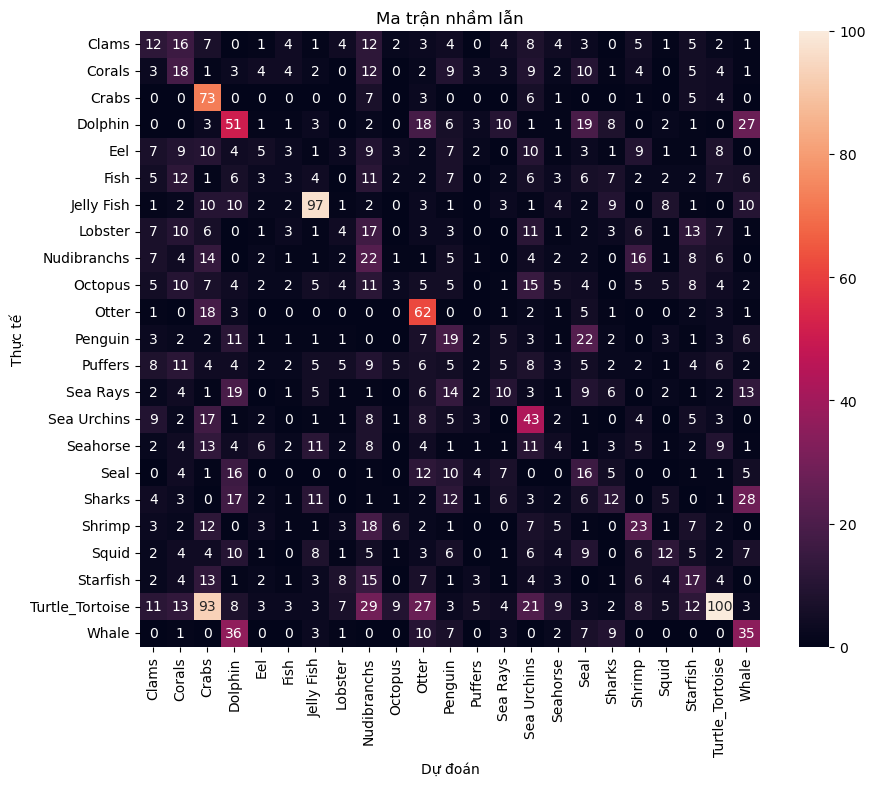

In [27]:
# Đánh giá mô hình 
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred, target_names=[class_mapping[i] for i in range(len(class_mapping))]))

# Hiển thị ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[class_mapping[i] for i in range(len(class_mapping))], yticklabels=[class_mapping[i] for i in range(len(class_mapping))])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn')
plt.show()

## Lưu mô hình

In [29]:
# Lưu scaler
scaler_output_path = '../models/scaler_color_histogram_gridsearch.pkl'
joblib.dump(scaler, scaler_output_path)
print(f"✓ Đã lưu scaler tại {scaler_output_path}")

# Lưu mô hình tốt nhất
model_output_path = '../models/svc_color_histogram_gridsearch.pkl'
joblib.dump(grid_search.best_estimator_, model_output_path)
print(f"✓ Đã lưu mô hình tại {model_output_path}")

✓ Đã lưu scaler tại ../models/scaler_color_histogram_gridsearch.pkl
✓ Đã lưu mô hình tại ../models/svc_color_histogram_gridsearch.pkl


In [30]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compare_models(model1, model2, X_test, y_test, model1_name="Model 1", model2_name="Model 2"): 
    # Dự đoán
    y_pred1 = model1.predict(X_test)
    y_pred2 = model2.predict(X_test)
    
    # Tính các metrics
    metrics = {
        'Model': [model1_name, model2_name],
        'Accuracy': [
            accuracy_score(y_test, y_pred1),
            accuracy_score(y_test, y_pred2)
        ],
        'Precision (Macro)': [
            precision_score(y_test, y_pred1, average='macro'),
            precision_score(y_test, y_pred2, average='macro')
        ],
        'Recall (Macro)': [
            recall_score(y_test, y_pred1, average='macro'),
            recall_score(y_test, y_pred2, average='macro')
        ],
        'F1-Score (Macro)': [
            f1_score(y_test, y_pred1, average='macro'),
            f1_score(y_test, y_pred2, average='macro')
        ],
        'Precision (Weighted)': [
            precision_score(y_test, y_pred1, average='weighted'),
            precision_score(y_test, y_pred2, average='weighted')
        ],
        'Recall (Weighted)': [
            recall_score(y_test, y_pred1, average='weighted'),
            recall_score(y_test, y_pred2, average='weighted')
        ],
        'F1-Score (Weighted)': [
            f1_score(y_test, y_pred1, average='weighted'),
            f1_score(y_test, y_pred2, average='weighted')
        ]
    }
    
    # Tạo DataFrame
    df = pd.DataFrame(metrics)
    
    # Làm tròn số
    for col in df.columns[1:]:
        df[col] = df[col].round(4)
    
    # In bảng
    print("\n" + "="*80)
    print("SO SÁNH KẾT QUẢ HAI MÔ HÌNH")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)
    
    # Tìm mô hình tốt hơn
    best_model = model1_name if df.loc[0, 'F1-Score (Macro)'] > df.loc[1, 'F1-Score (Macro)'] else model2_name
    print(f"\n🏆 Mô hình tốt nhất (theo F1-Score Macro): {best_model}")
    print("="*80 + "\n")
    
    return df

# Sử dụng hàm
comparison_df = compare_models(
    model1=model,  # Mô hình SVC cơ bản
    model2=grid_search.best_estimator_,  # Mô hình GridSearch
    X_test=X_test,
    y_test=y_test,
    model1_name="SVC (Default)",
    model2_name="SVC (GridSearch)"
)


SO SÁNH KẾT QUẢ HAI MÔ HÌNH
           Model  Accuracy  Precision (Macro)  Recall (Macro)  F1-Score (Macro)  Precision (Weighted)  Recall (Weighted)  F1-Score (Weighted)
   SVC (Default)    0.2461             0.2039          0.2317            0.1932                0.2617             0.2461               0.2223
SVC (GridSearch)    0.2344             0.1940          0.2190            0.1898                0.2428             0.2344               0.2188

🏆 Mô hình tốt nhất (theo F1-Score Macro): SVC (Default)

